## Parts of Speech Tagging & Named Entity Recognition

In [1]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [2]:
sentence = 'London is the capital and most populous city of England.'
# sentence = post
sentence_nlp = nlp(sentence)
print([(token.text, token.pos_) for token in sentence_nlp])

[('London', 'PROPN'), ('is', 'AUX'), ('the', 'DET'), ('capital', 'NOUN'), ('and', 'CCONJ'), ('most', 'ADV'), ('populous', 'ADJ'), ('city', 'NOUN'), ('of', 'ADP'), ('England', 'PROPN'), ('.', 'PUNCT')]


In [3]:
from spacy import displacy
displacy.render(sentence_nlp, jupyter=True,
                options={'distance': 110,
                         'arrow_stroke': 2,
                         'arrow_width': 8})

In [4]:
# Access named entities using the 'ents' attribute
named_entities = sentence_nlp.ents
print(named_entities)

(London, England)


In [5]:
# print named entities in article
print([(word.text, word.label_) for word in sentence_nlp.ents])

# visualize named entities
from spacy import displacy
displacy.render(sentence_nlp, style='ent', jupyter=True)

[('London', 'GPE'), ('England', 'GPE')]


# Word Cloud

In [6]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as mcolors
import re
import unicodedata

In [7]:
url = 'https://raw.githubusercontent.com/EunCheolChoi0123/COMM557Tutorial/refs/heads/main/Tutorial%203%20Reddit%20Scraper%20and%20Network/datascience-new-comment.csv'
df  = pd.read_csv(url)
df = df[~df.body.isna()]

df['body'] = df['body'].astype('str')
df['body']

,body
0,This one will give you a solid starting point ...
1,I’m an MCA student who just started this Septe...
2,"Oh yeah, that's a really good collection. It's..."
3,There is a dedicated thread you can use for th...
4,Thanks
...,...
104,"Thanks, this is good advice"
105,"I'd say hindrance. The data we have is OK, the..."
106,"Thanks, why?"
107,"Once you go into consultancy, it's very diffic..."


In [8]:
# remove HTML links and special characters
# choose functions that suit your neeeds

def strip_links(text):
    link_regex    = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links         = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ' ')
    return text

def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def process_posts(post):
    post = strip_links(post)
    post = remove_special_characters(post)
    return post

df.loc[:, 'body'] = df.body.apply(process_posts)

<>:5: SyntaxWarning: invalid escape sequence '\w'
<>:5: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipython-input-2342020926.py:5: SyntaxWarning: invalid escape sequence '\w'
  link_regex    = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)


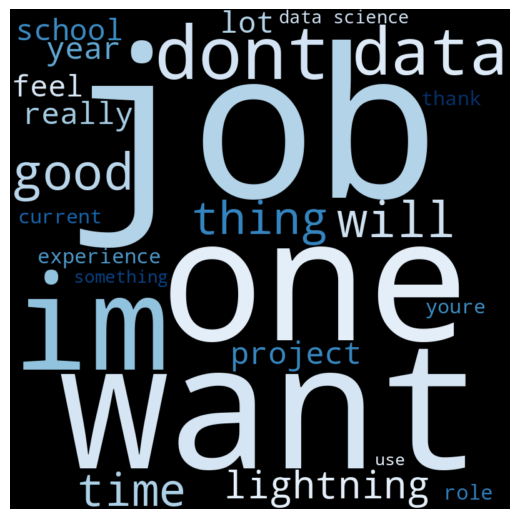

In [9]:
text = ' '.join(df.body.tolist()).lower()

# create the wordcloud object
wordcloud = WordCloud(width = 800, height = 800,
                #background_color ='white',
                stopwords = STOPWORDS,
                max_words=25,
                colormap='Blues', # Blues
                collocations = True,
                prefer_horizontal=1.0,
                min_font_size = 10).generate(text)

# plot word cloud
plt.figure(figsize = (5, 5), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.margins(x=0, y=0)
plt.axis("off")
plt.tight_layout(pad = 0)

In [10]:
import nltk
from nltk import ToktokTokenizer

### Run this the first time
nltk.download('stopwords')
nltk.download('punkt')

tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')

def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [11]:
df.loc[:, 'body'] = df.body.apply(remove_stopwords)

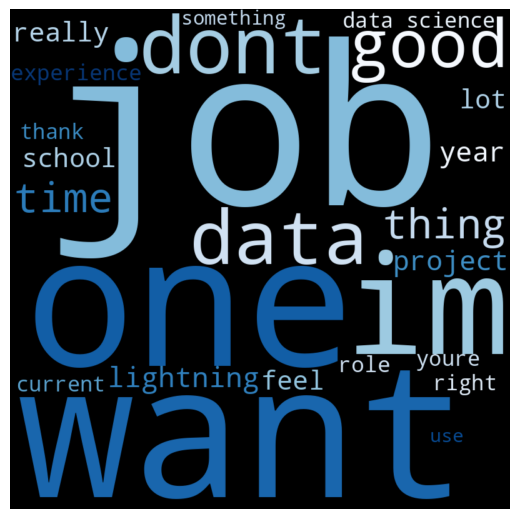

In [12]:
text = ' '.join(df.body.tolist()).lower()

# create the wordcloud object
wordcloud = WordCloud(width = 800, height = 800,
                #background_color ='white',
                stopwords = STOPWORDS,
                max_words=25,
                colormap='Blues', # Blues
                collocations = True,
                prefer_horizontal=1.0,
                min_font_size = 10).generate(text)

# plot word cloud
plt.figure(figsize = (5, 5), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.margins(x=0, y=0)
plt.axis("off")
plt.tight_layout(pad = 0)

# Semantic Network

In [13]:
!pip install vaderSentiment
!pip install gensim

In [32]:
import pandas as pd
import spacy
from datetime import datetime
import re
import string
from collections import Counter
import itertools
import networkx as nx
import unicodedata
import random
from gensim import corpora

### Load Twitter data

In [15]:
df['body'] = df['body'].astype('str')
df['body']

,body
0,one give solid starting point pivot depending ...
1,Im MCA student started September Im trying get...
2,Oh yeah thats really good collection super det...
3,dedicated thread use
4,Thanks
...,...
104,Thanks good advice
105,Id say hindrance data OK issue legacy systems ...
106,Thanks
107,go consultancy difficult move options would wo...


In [16]:
df = df[~df.body.isna()]

### Preprocessing Twitter Data

In [17]:
# remove HTML links and special characters
# choose functions that suit your neeeds

def strip_links(text):
    link_regex    = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links         = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ' ')
    return text

def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

<>:5: SyntaxWarning: invalid escape sequence '\w'
<>:5: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipython-input-3692070103.py:5: SyntaxWarning: invalid escape sequence '\w'
  link_regex    = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)


In [18]:
def process_posts(post):
    post = strip_links(post)
    post = remove_special_characters(post)
    return post

In [19]:
df.loc[:, 'body'] = df.body.apply(process_posts)
df.body

,body
0,one give solid starting point pivot depending ...
1,Im MCA student started September Im trying get...
2,Oh yeah thats really good collection super det...
3,dedicated thread use
4,Thanks
...,...
104,Thanks good advice
105,Id say hindrance data OK issue legacy systems ...
106,Thanks
107,go consultancy difficult move options would wo...


### Stemming/Lemming

In [20]:
# Stemming / Lemming

### loading a spacy language model
# python -m spacy download en_core_web_sm
# https://spacy.io/models/en

nlp = spacy.load('en_core_web_sm')

def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

In [21]:
post = df['body'][10]

print(post)
print('------\nstemmed post:')
print(simple_stemmer(post))
print('------\nlemmatized post:')
print(lemmatize_text(post))

much heavy lifting criticized Like suggest using lightning gave rationale Based thread feel like people think berated
------
stemmed post:
much heavi lift critic like suggest use lightn gave rational base thread feel like peopl think berat
------
lemmatized post:
much heavy lifting criticize like suggest use lightning give rationale base thread feel like people think berate


### Tokenizing and Corpus Creation

In [33]:
%%time
#Create corupus of all words
words_corpus = []
for elem in df.body:
    # remove stop words
    elem = remove_stopwords(elem)
    # lemmatize text
    elem = lemmatize_text(elem)
    words_corpus.append(elem.lower().split())
print(len(words_corpus))

dictionary = corpora.Dictionary(words_corpus)
print(len(dictionary))

109
1278
CPU times: user 1.43 s, sys: 4.34 ms, total: 1.43 s
Wall time: 1.44 s


#### Apply this to the entire dataframe

In [34]:
%%time
df["text_processed"] = df.body.apply(remove_stopwords)
df["text_processed"] = df.text_processed.apply(lemmatize_text)
df["text_processed"] = df.text_processed.apply(lambda x: x.lower().split())

CPU times: user 1.37 s, sys: 1.19 ms, total: 1.37 s
Wall time: 1.38 s


# RUN UNTIL HERE TO FOLLOW DURING CLASS

In [35]:
df["text_tups"] = df.text_processed.apply(lambda x: list(itertools.combinations(x, 2)))
all_tups = [item for sublist in df.text_tups.values for item in sublist]
all_tups = Counter(all_tups)

In [36]:
word_edges = all_tups.most_common(1000)
word_edges = [(w[0][0], w[0][1], w[1] ) for w in word_edges]

In [37]:
G = nx.Graph()
G.add_weighted_edges_from(word_edges)

In [38]:
G.remove_edges_from(nx.selfloop_edges(G))

In [39]:
connected_components = sorted(nx.connected_components(G), key=len, reverse=True)
largest_component = connected_components[0]
G = G.subgraph(largest_component)

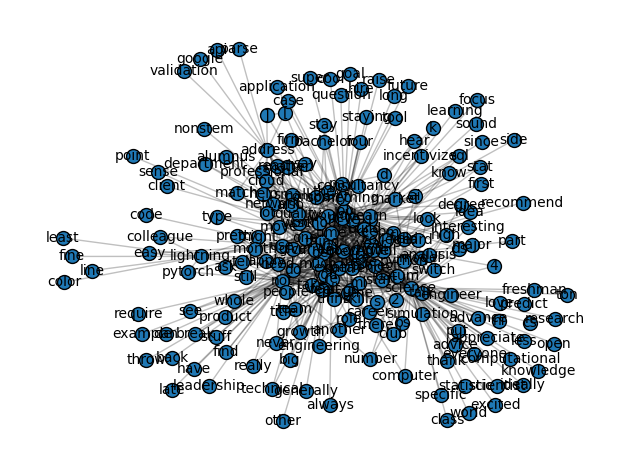

In [40]:
import matplotlib.pyplot as plt

pos = nx.spring_layout(G, seed=200)
nx.draw_networkx_edges(G, pos, alpha=0.25, width=1)
nx.draw_networkx_nodes(G, pos, node_size=100).set_edgecolor('black')

# Add labels to the nodes
labels = {node: str(node) for node in G.nodes()}  # Replace str(node) with your actual labels
nx.draw_networkx_labels(G, pos, labels, font_size=10, font_color='black')

plt.tight_layout()
plt.axis("off")
plt.show()

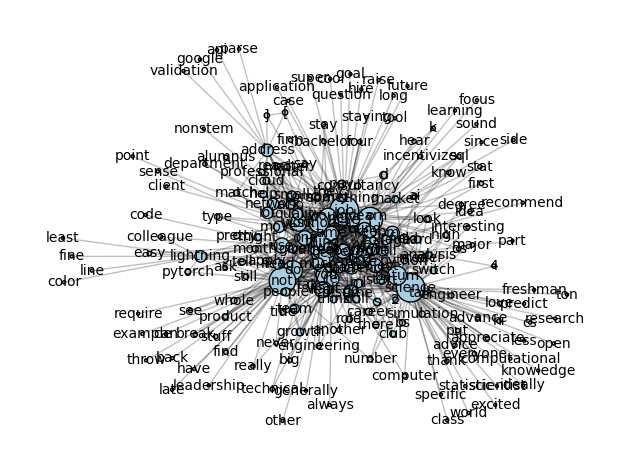

In [41]:
degree_centrality = nx.degree_centrality(G)
scaled_degree_centrality = {node: deg * 1000 for node, deg in degree_centrality.items()}  # Scale it up for visualization

# Lighter node colors
node_colors = ['#a6cee3' for _ in G.nodes()]

# Node positions
pos = nx.spring_layout(G, seed=200)

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.25, width=1)

# Draw nodes with lighter colors and scaled sizes
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=list(scaled_degree_centrality.values())).set_edgecolor('black')

# Add standout labels to the nodes
labels = {node: str(node) for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels, font_size=10, font_color='black')

# Show the graph
plt.tight_layout()
plt.axis("off")
plt.show()

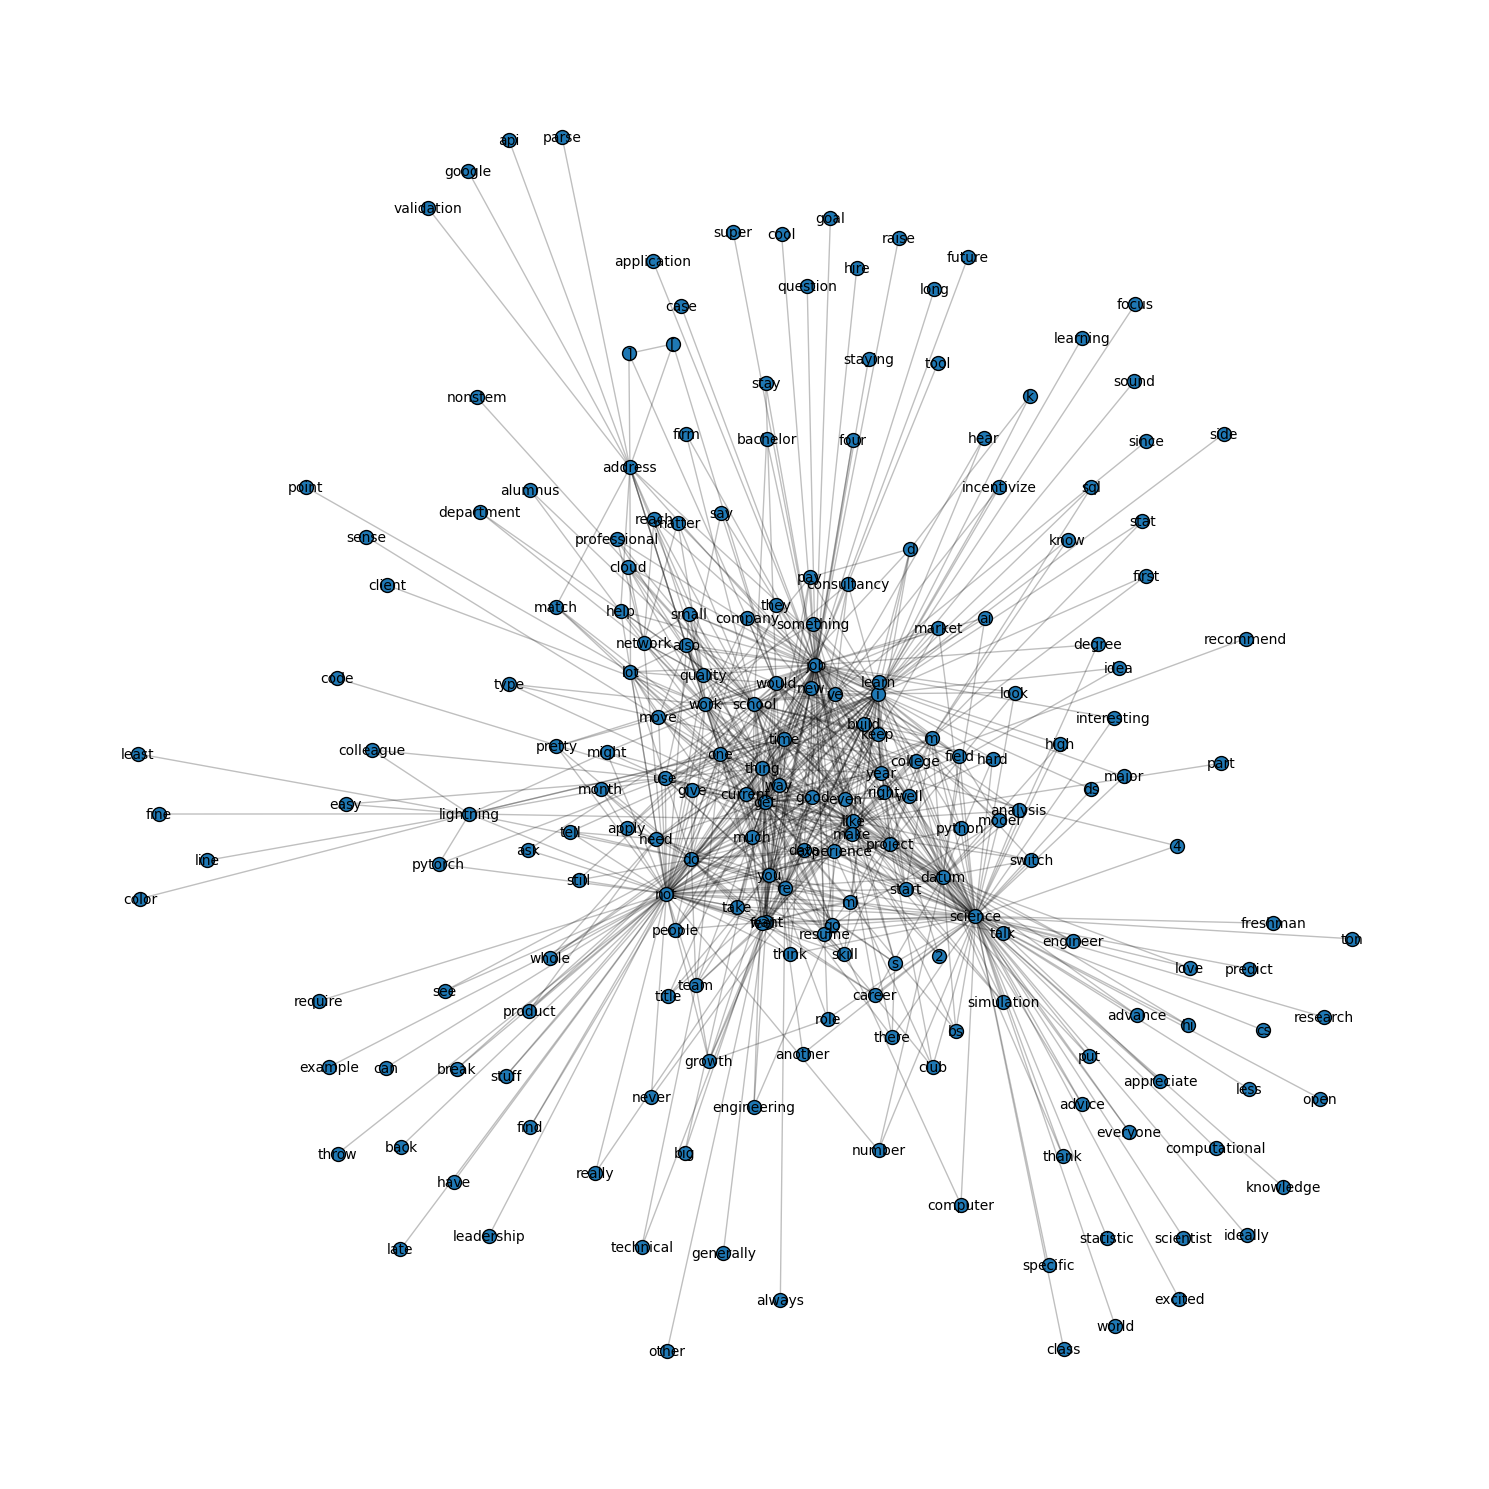

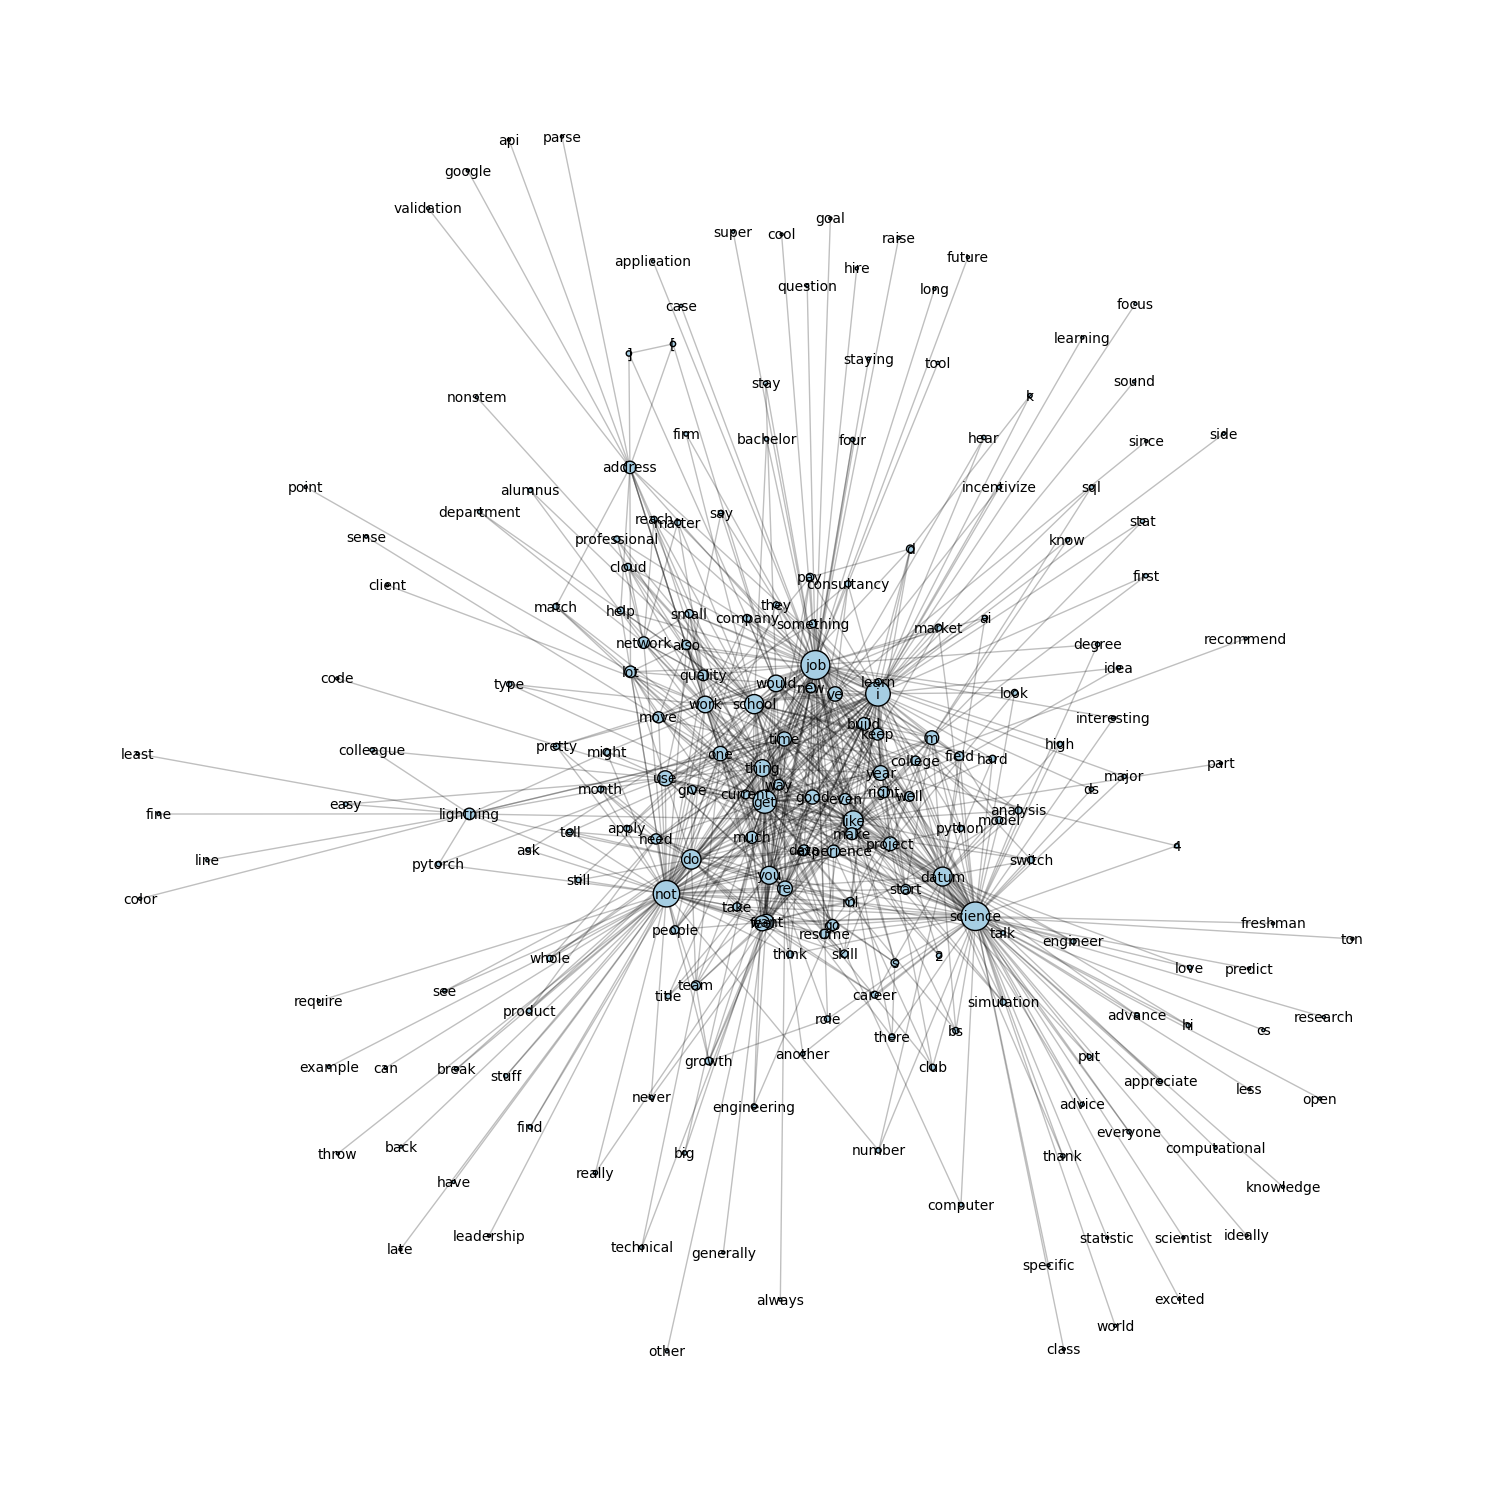

In [42]:
# prompt: make above plot larger

plt.figure(figsize=(15, 15))  # Increase the figure size for a larger plot

pos = nx.spring_layout(G, seed=200)
nx.draw_networkx_edges(G, pos, alpha=0.25, width=1)
nx.draw_networkx_nodes(G, pos, node_size=100).set_edgecolor('black')

# Add labels to the nodes
labels = {node: str(node) for node in G.nodes()}  # Replace str(node) with your actual labels
nx.draw_networkx_labels(G, pos, labels, font_size=10, font_color='black')

plt.tight_layout()
plt.axis("off")
plt.show()

degree_centrality = nx.degree_centrality(G)
scaled_degree_centrality = {node: deg * 1000 for node, deg in degree_centrality.items()}  # Scale it up for visualization

# Lighter node colors
node_colors = ['#a6cee3' for _ in G.nodes()]

# Node positions
pos = nx.spring_layout(G, seed=200)

plt.figure(figsize=(15, 15))  # Increase the figure size for a larger plot

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.25, width=1)

# Draw nodes with lighter colors and scaled sizes
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=list(scaled_degree_centrality.values())).set_edgecolor('black')

# Add standout labels to the nodes
labels = {node: str(node) for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels, font_size=10, font_color='black')

# Show the graph
plt.tight_layout()
plt.axis("off")
plt.show()
